In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import utils
%matplotlib inline
import importlib
importlib.reload(utils)
import seaborn as sns
from scipy.stats.mstats import winsorize

## Data acquisition

In [ ]:
df = pd.read_csv("stock data/Consumer Goods & Retail/MSN_RRV.csv")
df

## Data preprocessing

In [ ]:
df = utils.clean(df)
df = utils.reverse_inplace(df)

In [ ]:
df

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

In [ ]:
df.describe()

### Detect outliers

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Boxplot for Prices
sns.boxplot(data=df[["Open", "High", "Low", "Price"]], ax=axes[0])
axes[0].set_title("Stock Price Distribution")

# Boxplot for Volume
sns.boxplot(x=df["Vol."], ax=axes[1])
axes[1].set_title("Trading Volume Distribution")

plt.show()


In [ ]:
# Calculate IQR
Q1 = df[["Open", "High", "Low", "Price"]].quantile(0.25)
Q3 = df[["Open", "High", "Low", "Price"]].quantile(0.75)
IQR = Q3 - Q1

# Define outlier limits
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = ((df[["Open", "High", "Low", "Price"]] < lower_bound) | 
            (df[["Open", "High", "Low", "Price"]] > upper_bound)).any(axis=1)

# Print number of outliers
print(f"Number of outliers: {outliers.sum()}")


In [ ]:
# Compute IQR for Volume
Q1 = df["Vol."].quantile(0.25)
Q3 = df["Vol."].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
volume_outliers = (df["Vol."] < lower_bound) | (df["Vol."] > upper_bound)

# Print number of outliers
print(f"Number of outliers in Volume: {volume_outliers.sum()}")

- There are 10 outliers in columns "Open", "High", "Low", "Price", and 266 in "Vol."

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df["Date"], df["Vol."], label="Trading Volume", alpha=0.7)
plt.scatter(df["Date"][volume_outliers], df["Vol."][volume_outliers], color='red', label="Outliers")
plt.legend()
plt.title("Trading Volume Over Time")
plt.show()


- Based on the plot, we can assume that the outliers in trading volume are market-driven 
- -> We can keep them and create a new feature Relative Volume (RVOL), which measures the change between today's volume and avg of past 30 days
- If RVOL > 1, it means volume is higher than usual, signaling potential trend changes.
- If RVOL < 1, it means trading activity is lower than normal.

In [ ]:
df["Avg_Vol"] = df["Vol."].rolling(window=30).mean()
df["RVOL"] = df["Vol."] / df["Avg_Vol"]

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df["Date"], df["RVOL"])
plt.axhline(y=1, color="red", linestyle="--", label="y = 1")

In [ ]:
df = df.drop("Avg_Vol", axis=1)

## EDA

### Check the distribution

In [ ]:
numeric_cols = df.columns[1: 8]

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)  # Adjust subplot grid if needed
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

### Time series analysis

<Axes: xlabel='Date'>

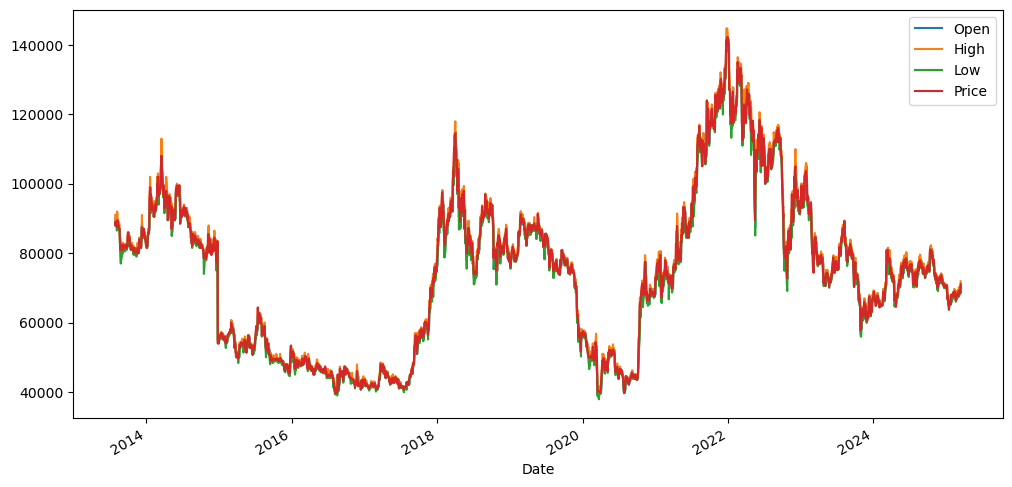

In [19]:
df.set_index('Date')[['Open','High','Low','Price']].plot(figsize=(12,6))

- Significant fluctuations in stock prices are evident, particularly in certain periods (e.g., sharp increases around 2021–2022 - Covid pandemic).
- The stock price seems to have certain levels where it tends to reverse (support levels) or face resistance (resistance levels). -> Identifying these levels will help.
- The OHLC values are closely aligned, meaning that the Open, High, Low, and Close prices move together in a consistent manner.


In [34]:
df['Month'] = df['Date'].dt.month

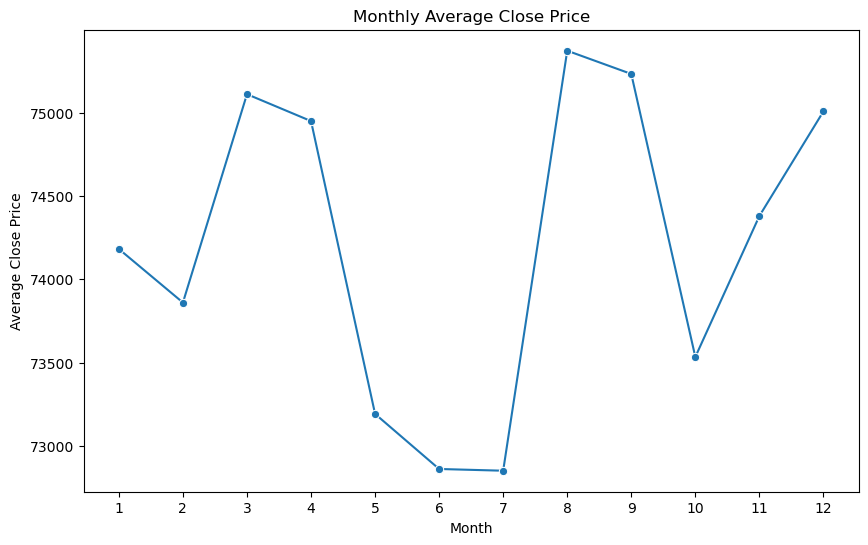

In [35]:
# Group by month and compute the average of Close price
monthly_avg = df.groupby('Month')['Price'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=monthly_avg, x='Month', y='Price', marker='o')
plt.title('Monthly Average Close Price')
plt.xlabel('Month')
plt.ylabel('Average Close Price')
plt.xticks(range(1, 13))  # ensure all months are shown if applicable
plt.show()

- The chart shows a notable dip around months 6–7 (lowest average Close Prices) and a peak around months 8–9 (highest average Close Prices) -> This suggests that there may be seasonal effects where prices tend to be lower in the mid-year and higher in late summer or early fall.

/var/folders/sg/hvb_09sx5cz3k3tn8fwysqd00000gn/T/ipykernel_8130/870766790.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_volume, x='Month', y='Vol.', palette='viridis')


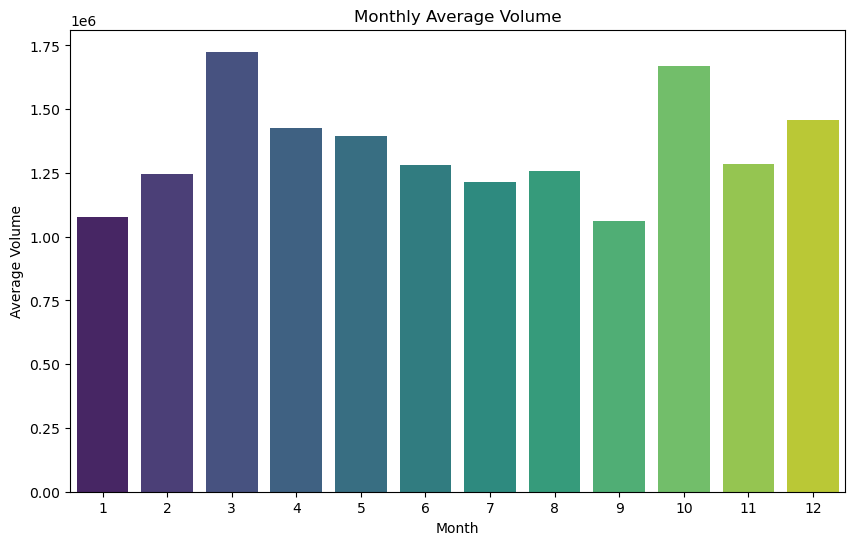

In [36]:
monthly_volume = df.groupby('Month')['Vol.'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=monthly_volume, x='Month', y='Vol.', palette='viridis')
plt.title('Monthly Average Volume')
plt.xlabel('Month')
plt.ylabel('Average Volume')
plt.show()


- The chart suggests higher trading activity in certain months (e.g., months 2–4, and again around month 10).
- A noticeable dip in average volume appears mid-year (months 6–8). A common phenomenon in many markets is a summer slowdown, where investors and traders are less active.


### Correlations

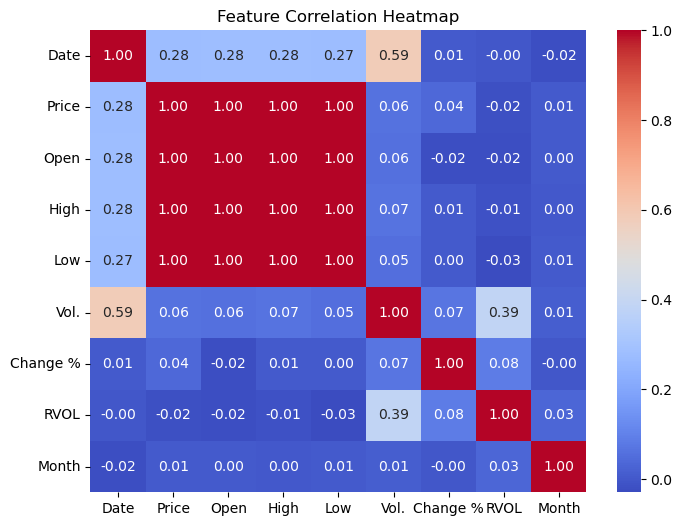

In [40]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
sns.pairplot(df[['Open','High','Low','Price','Vol.','Change %']])

### Volume analysis

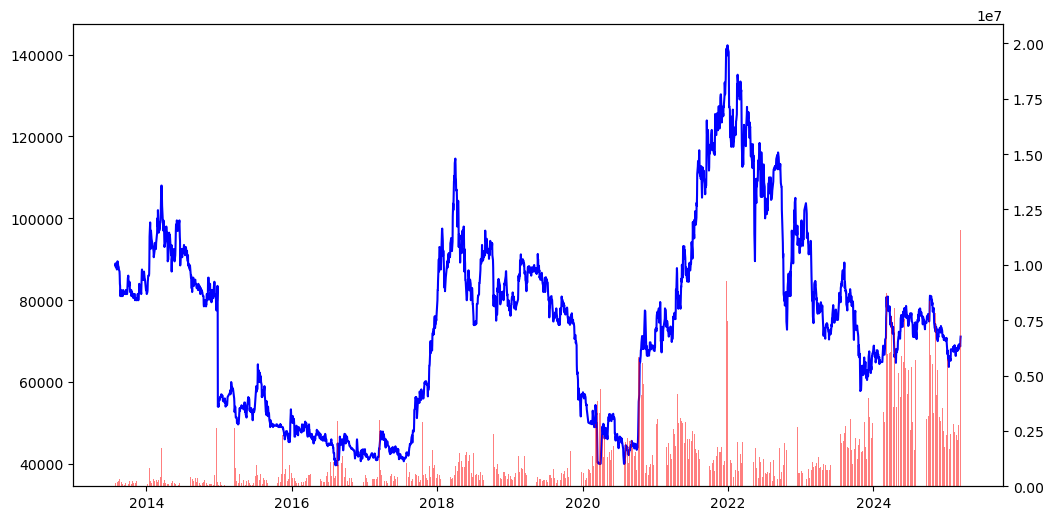

In [49]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df["Date"], df['Price'], color='blue')
ax2 = ax1.twinx()
ax2.bar(df["Date"], df['Vol.'], color='red', alpha=0.5)
plt.show()

- Volume bars show spikes at various points that often coincide with significant price movements.
- The height of the volume bars may shift gradually over the entire timespan. If you notice that recent volume bars tend to be higher than earlier ones, it could indicate changing liquidity in the market.